## Imports
If used on a new device will also need to install all below packages

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Point, LineString, Polygon
from sklearn.metrics import r2_score
import scipy
%matplotlib inline

## Reading Files

In [2]:
#Read in Files - This takes a LONG time ~3mins. Do not run unless necessary
#Census Block Group base information
BG_raw = gpd.read_file('../CensusData/nhgis0006_shapefile_tl2020_us_blck_grp_2020.zip')
#plot base information
plots = pd.read_csv("../FIAData/ID_PLOT.csv")
#base tree information
trees = pd.read_csv("../FIAData/ID_TREE.csv")
#metro area information
metro = gpd.read_file('../MetroAreas/tl_2019_us_cbsa.zip')

## Entering Variables 
This should be the only edit when looking at different variables for trees, census, and differet summary statistics

In [3]:
#Set variables for what data and how it is aggregated as well as tree variable and aggregation
#Set variables for cities chosen.
data = pd.read_csv('../CensusData/nhgis0007_ds249_20205_blck_grp.csv') ## data to be read in
#Name of column in Dataframe
dataString = 'AMR8E001'
#name of folder and graphs
dataVars = 'Average Household Income'
#Aggregation Statistics
howData = 'mean'
#filter out unwanted data
filter0 = 0
#Name of Column in data frame
treeVar = 'SPCD'
#Aggregation statistic Currently only mean and sum are programed. Must program in others if want to use
howTree = 'unique'
#Name of folder and graphs
treeVars = "Number Tree Species"
#cities to execute
cities = ['Austin-Round Rock','Houston', 'San Antonio', 'Portland-Vancouver', 'San Diego', 'Springfield, MO', 'Kansas City', 'St. Louis', 'Washington-Arlington', 'Chicago']
#cities = ['Austin-Round Rock']
#Directory for images to be saved
parent_dir = "C:/Users/elimr/anaconda3/Environment/ResearchProject/UrbanFIAAnalysis/Figures"

### clean and fix plots data

In [4]:
### #add geometry and convert to geodataframe
geometry = gpd.points_from_xy((plots['LON']).astype(float),(plots['LAT']).astype(float))
plots['geometry'] = geometry 
plotsG = gpd.GeoDataFrame(plots, crs = "EPSG:4326" , geometry = geometry)
#convert to Albers
plotsG_A = plotsG.to_crs("ESRI:102003")

In [5]:
#Plot to look at all FIA plots
#fig, ax = plt.subplots(figsize=(6, 6))
#plt.title("FIA Plots")
#plotsBase = plotsG_A.plot(ax = ax, kind = 'geo',markersize=1)
#cx.add_basemap(plotsBase,crs="ESRI:102003")

### Clean and fix tree data.

Create dictionary of tree species and assign to trees

In [6]:
import csv
reader = csv.DictReader(open("../FIAData/REF_SPECIES.csv"))
mydict = {rows['SPCD']:rows['COMMON_NAME'] for rows in reader}
mydict
trees2 = trees
trees2['name'] = trees2['SPCD'].astype(str)
trees2=trees2.replace({"name": mydict})

### Clean and fix block group data, Merge plots to block groups

In [7]:
#Create County State variable which reduces time by removing uncessary census block groups
plotsG_A['CountSt'] = plotsG_A['COUNTYCD'] * 100 + plotsG_A['STATECD']
BG_raw['CountSt'] = BG_raw['COUNTYFP'].astype(int) * 100 + BG_raw['STATEFP'].astype(int)
#Merge census data to Block groups
BG_merged = pd.merge(data,BG_raw,on='GISJOIN')
#Merge tree data to block groups on created columns
BG = BG_merged[(BG_merged.CountSt).isin(plotsG_A['CountSt'])]
#Convert to geo data frame
BG = gpd.GeoDataFrame(BG, crs = "ESRI:102003" , geometry = BG['geometry'])

In [8]:
#Show Census Blocks
#fig, ax = plt.subplots(figsize=(6, 6))
#plt.title("Census Blocks")
#BGBase = BG.plot(ax = ax, kind = 'geo',alpha = .5, aspect=1, edgecolor = "black")
#cx.add_basemap(BGBase,crs="ESRI:102003")

### Perform geospatial analysis
1. buffer plots
2. intersect plots and block groups
3. dissolve intersect
4. merge back to trees

In [9]:
#create new data frame for buffer to fill
buffer = plotsG_A.copy()
#create a series of our plots geometries and convert crs to albers
#Needs to be a geoseries which is why directly referencing the column did not work
series = gpd.GeoSeries(plotsG_A.geometry)
series = series.to_crs("ESRI:102003")
#buffer the geometry by 1km - 1000m
buffer['geometry'] = series.buffer(1000)
#Convert buffer to geodataframe
bufferG = gpd.GeoDataFrame(buffer, crs = "ESRI:102003" , geometry = buffer['geometry']) 
#simplify BG information to just geometry and data.
BGData = BG[['geometry', dataString]]
#Overlay block group on or buffer. This intersects block groups and plots buffer.
overlay = BGData.overlay(bufferG,how='intersection')
#Dissolve by plots. Now 1 measuring area per plot with aggregation statistic howData set at top
dissolve = overlay.dissolve(by = 'PLOTID', aggfunc = {dataString: howData})
dissolve = dissolve.loc[dissolve[dataString].notnull()]

In [10]:
moneyTree = pd.merge(trees2,dissolve,on='PLOTID')
geometry = moneyTree['geometry']
treesG = gpd.GeoDataFrame(moneyTree, crs = "ESRI:102003" , geometry = geometry)

In [11]:
#Show final FIA pltos
#fig, ax = plt.subplots(figsize=(6,6))
#plt.title("FIA Plots")
#plotBase = overlay.plot(ax = ax, kind = 'geo')
#cx.add_basemap(plotBase,crs = "ESRI:102003")

## Loop and print data for all cities

Folder Exists - Skipping to Graphs


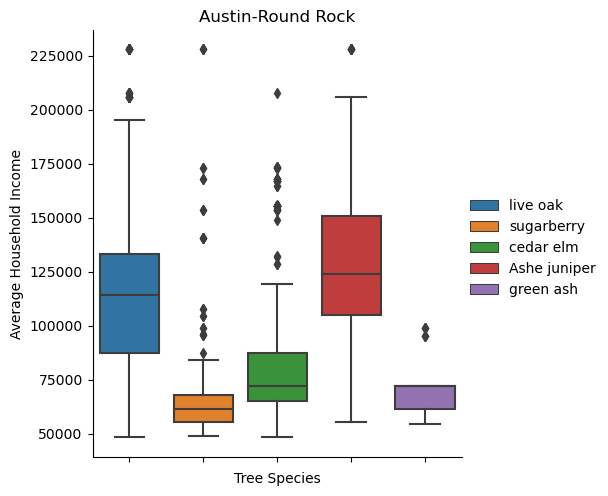

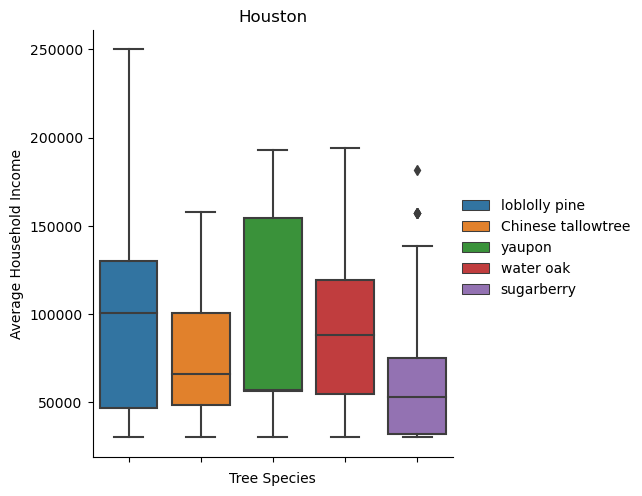

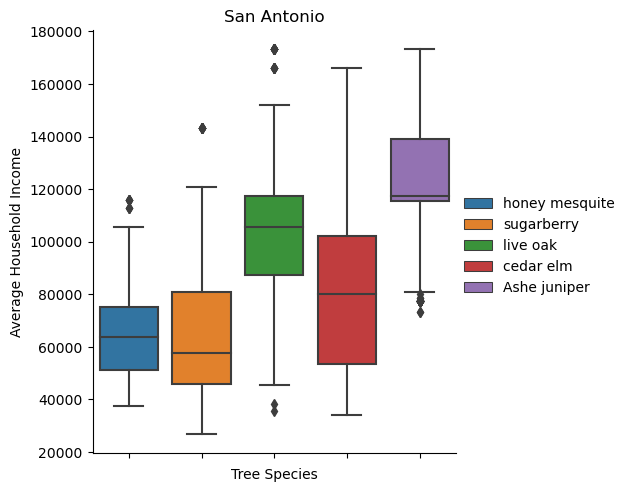

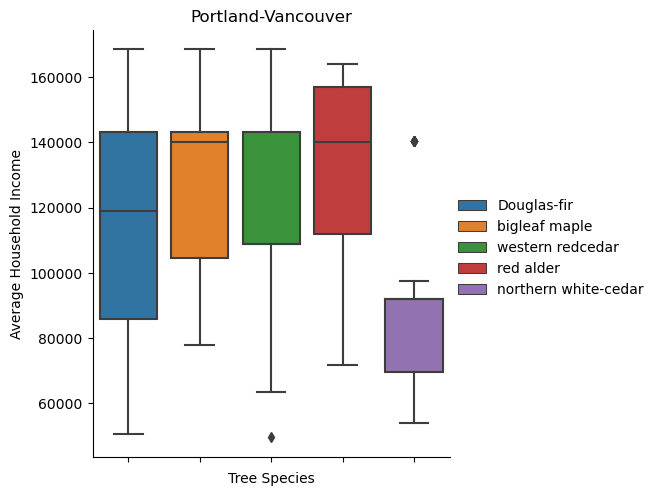

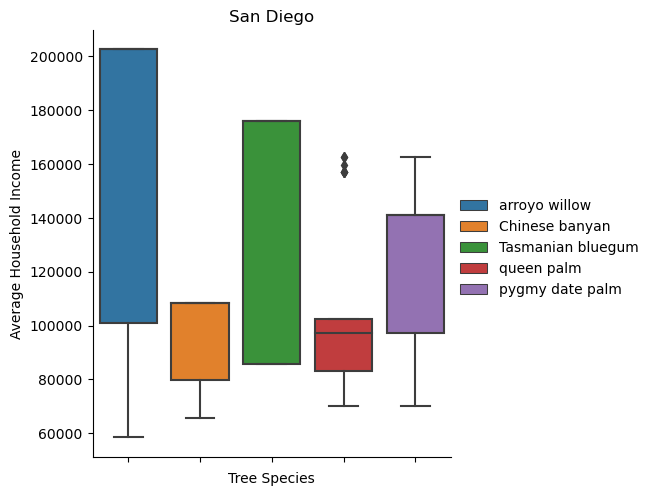

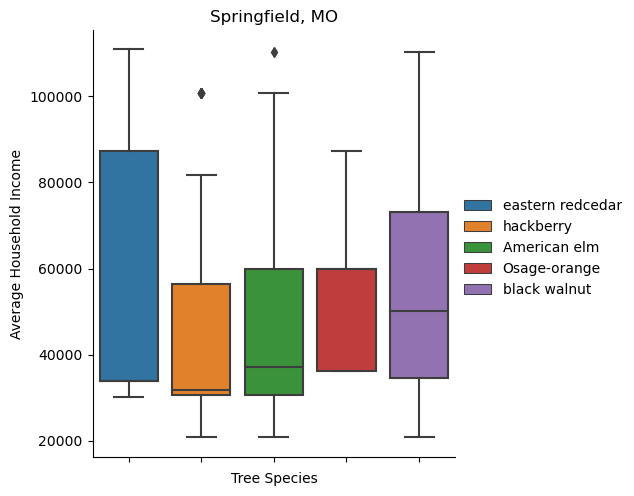

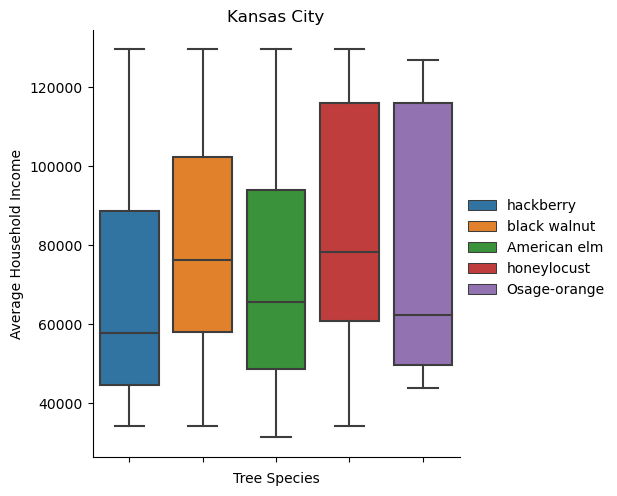

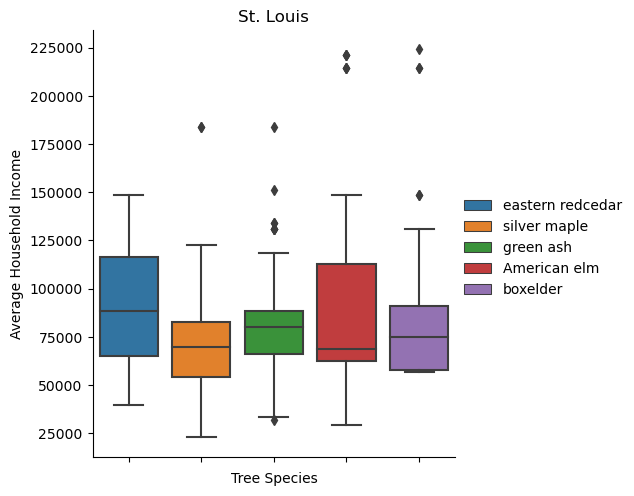

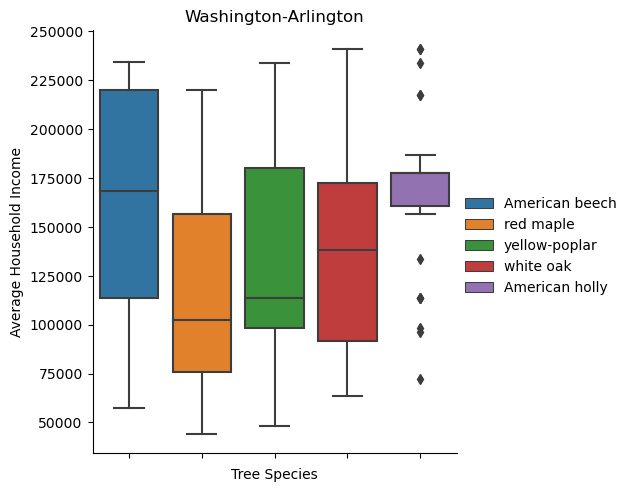

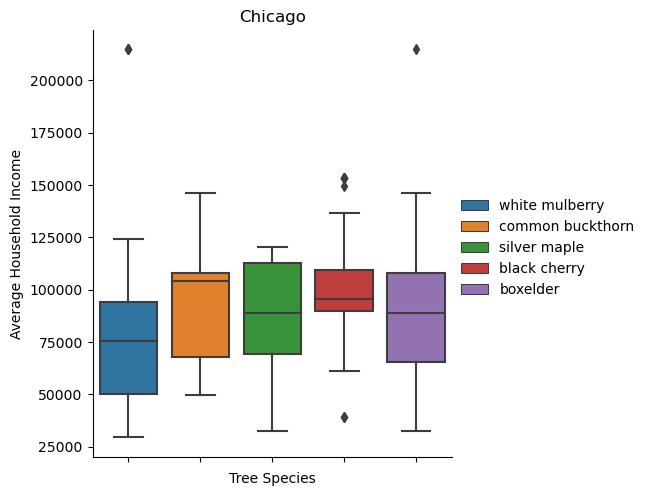

In [12]:
#Create directory to store figures
# Directory 
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns

directory = 'Species Diversity Boxplots'
# Path - Parent dir set in variables at top
path = os.path.join(parent_dir, directory) 
try: 
    os.mkdir(path) 
except OSError as error: 
    print("Folder Exists - Skipping to Graphs")  
#Convert metro area information to albers
metroA = metro.to_crs("ESRI:102003")
#filter metro information for only cities needed
metroA = metroA[metroA['NAME'].str.contains('|'.join(cities))]
for i in range(len(cities)):
    city = cities[i]
    #filter metro area again for specific city.
    metroCity = metroA[metroA['NAME'].str.contains(city)]
    #Clip plots by selected city
    clip = gpd.clip(treesG,metroCity)
    
    #Filter trees by number of trees
    #counts_trees = clip.groupby("name")["name"].transform(len)
    #mask = (counts_trees > 50)
    #clip = clip[mask]
    
    #Filter trees by most common occuring trees
    n = 5
    tree5 = clip['name'].value_counts()[:n].index.tolist()
    clip = clip[clip['name'].isin(tree5)]
    
    
    #Plot species diversity against income
    #g = sns.boxplot(data=clip, x='name', y=dataString)
    g = sns.catplot(kind='box', data=clip, x='name', y=dataString, hue='name',
                dodge=False, palette=sns.color_palette(), legend_out=True)
    plt.title(city)
    plt.xlabel('Tree Species')
    plt.ylabel(dataVars)
    g.add_legend()
    g.set_xticklabels('')
    #Save figures to directory
    plt.savefig('Figures/'+ directory + '/' +city+ '.png')
    plt.show()

